In [28]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv
import cellrank as cr
import anndata as ad
from cellrank.kernels import ConnectivityKernel, VelocityKernel
from cellrank.estimators import GPCCA
#from tueplots import bundles
#from tueplots import axes

In [29]:
cr.logging.print_versions()

cellrank==1.5.1+g525b847 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.5 numba==0.56.4 scipy==1.10.0 pandas==1.5.2 pygpcca==1.0.4 scikit-learn==1.2.0 statsmodels==0.13.5 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.6.2 seaborn==0.12.2


In [ ]:
org_adata = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/gastrulation/adata_gastrulation.h5ad")
org_adata.obs['celltype'].unique()

In [ ]:
leave_out_stage = ['E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0']
leave_in_cell = ['Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3']
adata = org_adata[~org_adata.obs["stage"].isin(leave_out_stage)].copy()
adata = adata[adata.obs["celltype"].isin(leave_in_cell)].copy()

map_dict = {"E6.5": 6.5, "E6.75": 6.75, "E7.0": 7.0, "E7.25": 7.25, "E7.5": 7.5, "E7.75": 7.75, "E8.0": 8.0,
            "E8.25": 8.25, "E8.5": 8.5}
adata.obs["stage"] = adata.obs["stage"].copy().map(map_dict)

adata.obs = adata.obs.loc[:, ['stage', 'celltype']]
adata.var = adata.var[[]]

sc.pp.log1p(adata)

In [ ]:
adata_825 = adata[adata.obs['stage'] == 8.25, :].copy()
adata_85 = adata[adata.obs['stage'] == 8.5, :].copy()

In [ ]:
sc.pp.pca(adata_825, n_comps=50)
scv.pp.moments(adata_825)
scv.tl.recover_dynamics(adata_825, n_jobs=80)
scv.tl.velocity(adata_825, mode = 'dynamical')

In [ ]:
sc.pp.pca(adata_85, n_comps=50)
scv.pp.moments(adata_85)
scv.tl.recover_dynamics(adata_85, n_jobs=80)
scv.tl.velocity(adata_85, mode = 'dynamical')

In [ ]:
adata = ad.concat([adata_825, adata_85])
sc.pp.neighbors(adata)
scv.tl.umap(adata)
adata

In [ ]:
adata.write("/home/icb/jonas.flor/precomputed_data/scvelo_branch_gast_pre.h5ad")

In [30]:
adata = sc.read("/home/icb/jonas.flor/precomputed_data/scvelo_branch_gast_pre.h5ad")
adata

AnnData object with n_obs × n_vars = 4645 × 53801
    obs: 'stage', 'celltype', 'n_counts'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

In [31]:
vk = VelocityKernel(adata).compute_transition_matrix()

100%|██████████████████████████████████████████████████████████████████████████████████| 4645/4645 [00:02<00:00, 2083.76cell/s]


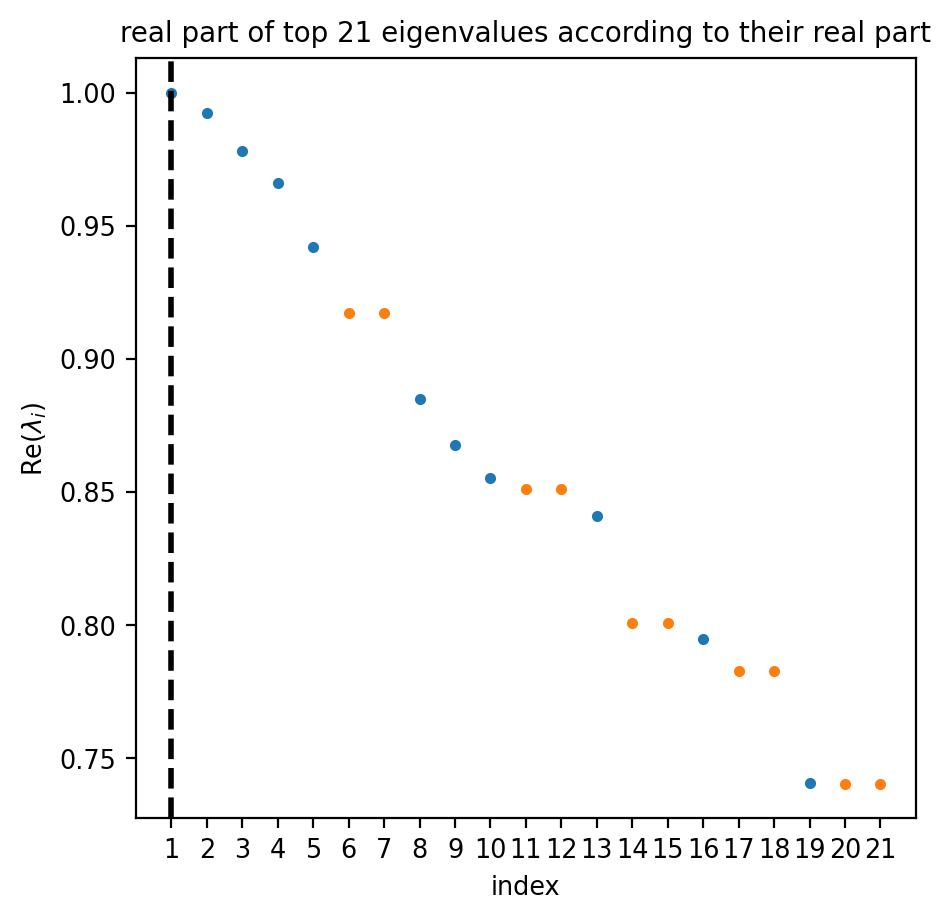

In [32]:
g = GPCCA(vk)
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


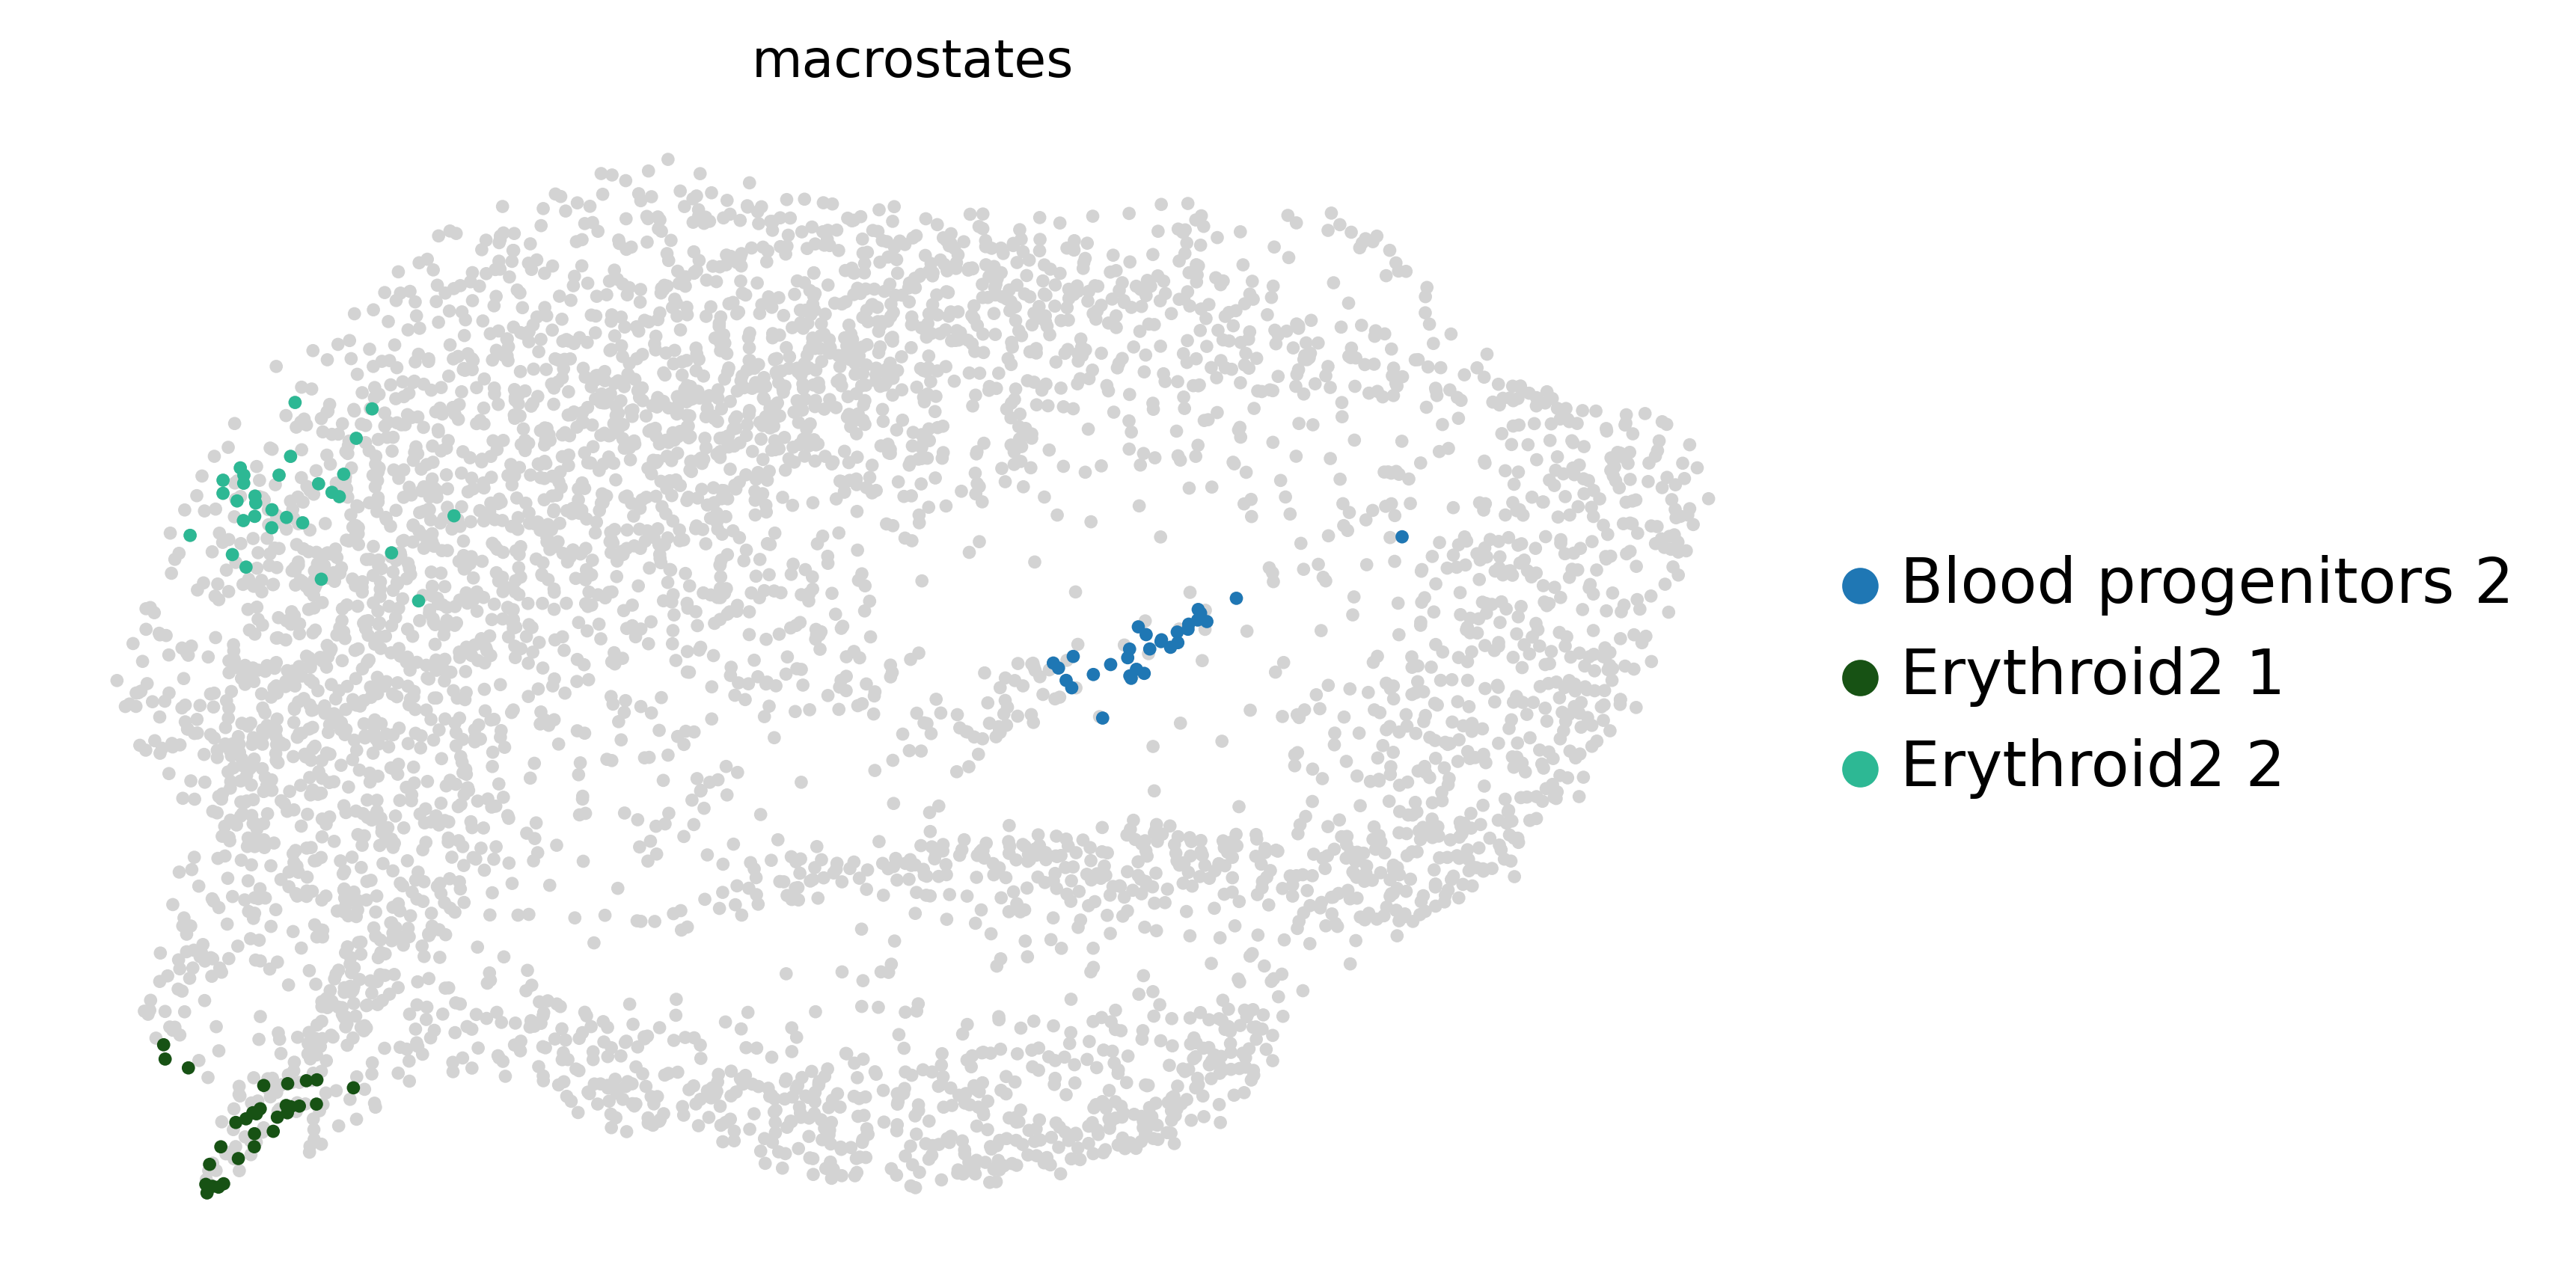

In [34]:
g.compute_macrostates(n_states=3, cluster_key="celltype")
scv.set_figure_params('scvel o', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


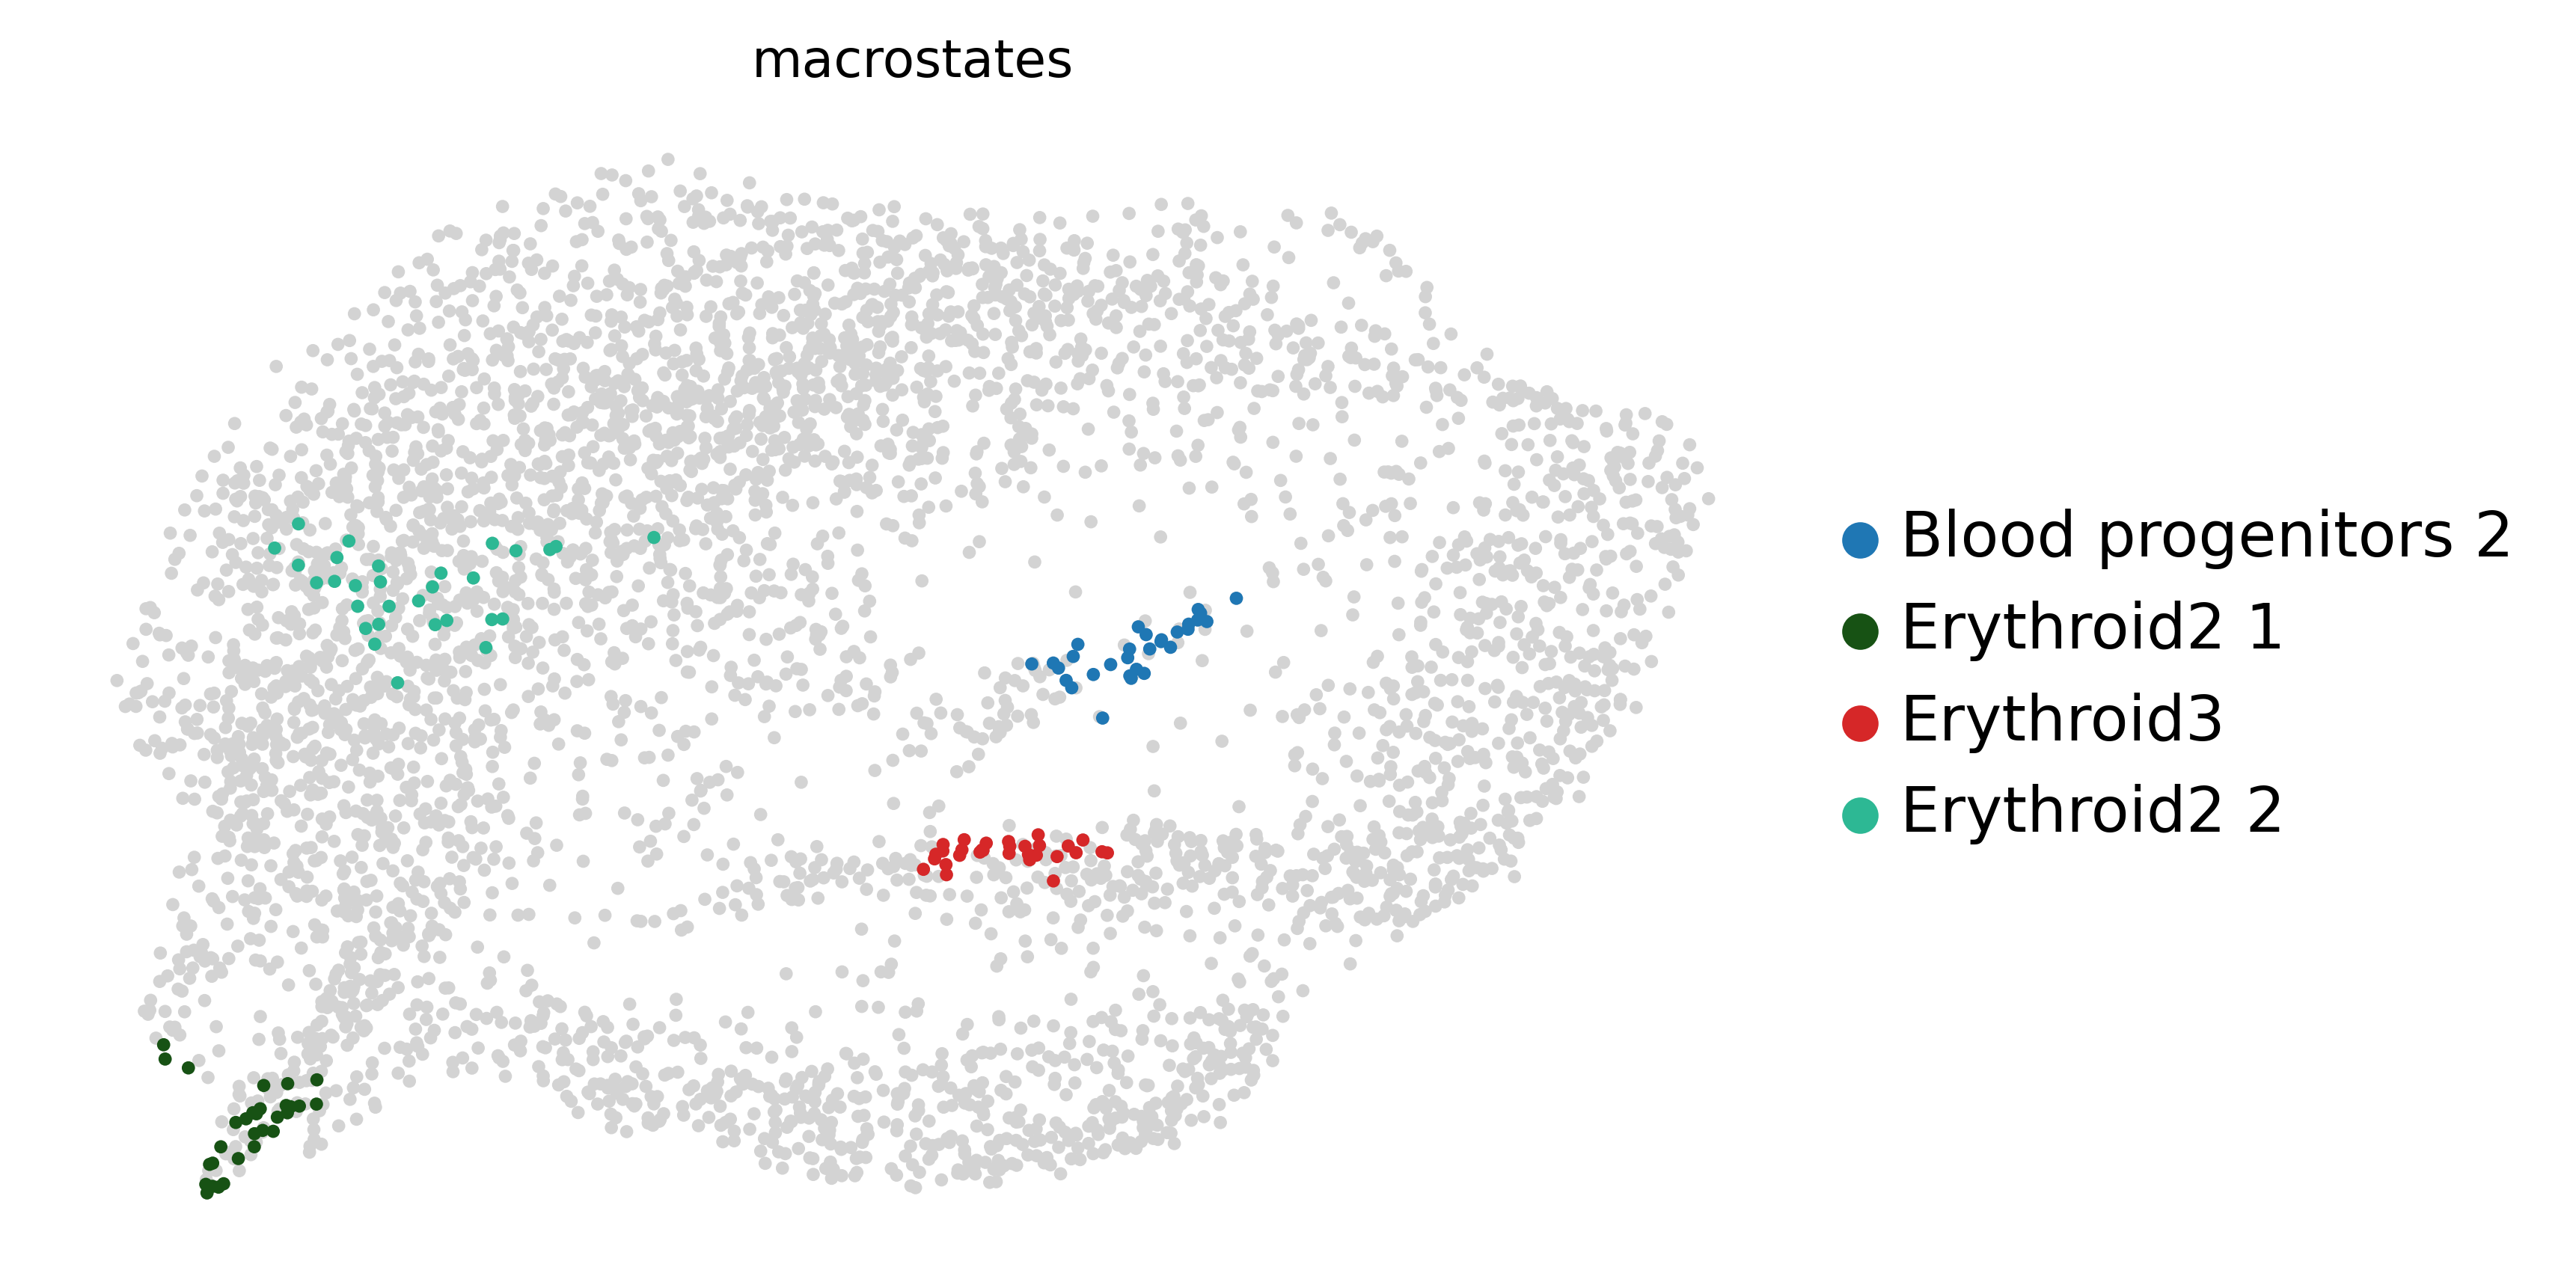

In [35]:
g.compute_macrostates(n_states=4, cluster_key="celltype")
scv.set_figure_params('scvel o', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

In [ ]:
g.set_terminal_states_from_macrostates(
    [
        'Erythroid' 
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu', time_to_absorption='all')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

In [ ]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=['Erythroid3'],
    cluster_key='celltype',
    clusters=['Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3'],
    figsize=(17, 6),
    title="",
    #save="transprobs_pancreas1415_scvelo.png"
)

<Figure size 600x400 with 0 Axes>

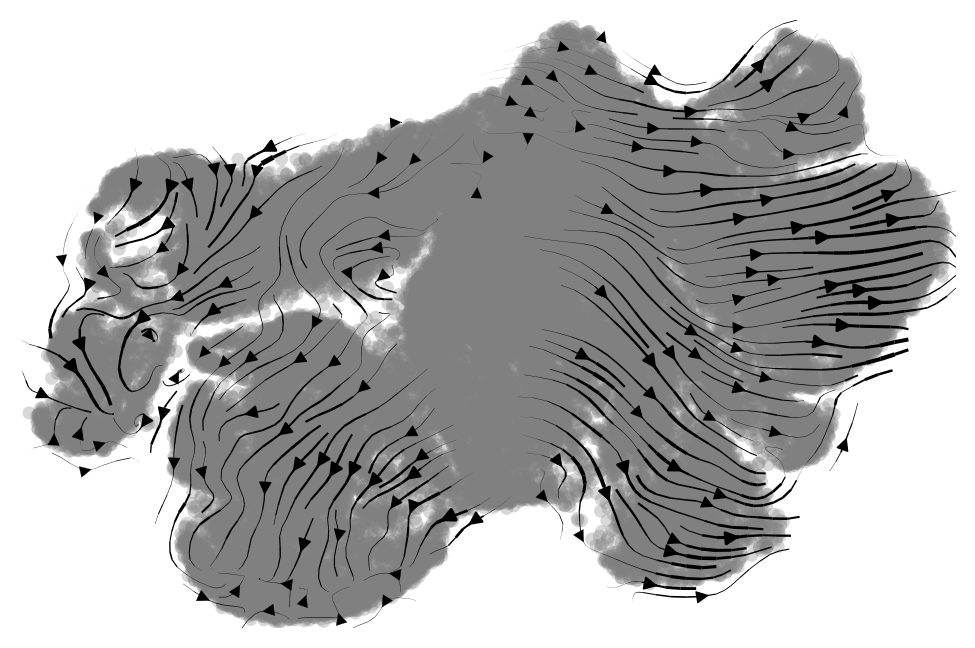

In [25]:
adata.uns["velocity_graph"] = vk.transition_matrix

scv.set_figure_params('scvelo', transparent=True, fontsize=10, dpi_save=400,color_map='viridis')
fig = plt.figure()
ax = scv.pl.velocity_embedding_stream(adata, basis="umap", smooth=0.5, title="")#, legend_loc="none", show=False)
#legend =ax.legend(bbox_to_anchor=[1.25, 1.5], loc='upper center', ncol=6,frameon=True, prop={'size': 18})

computing velocity embedding
    finished (0:00:14) --> added
    'velocity_emb', embedded velocity vectors (adata.obsm)


<Figure size 600x400 with 0 Axes>

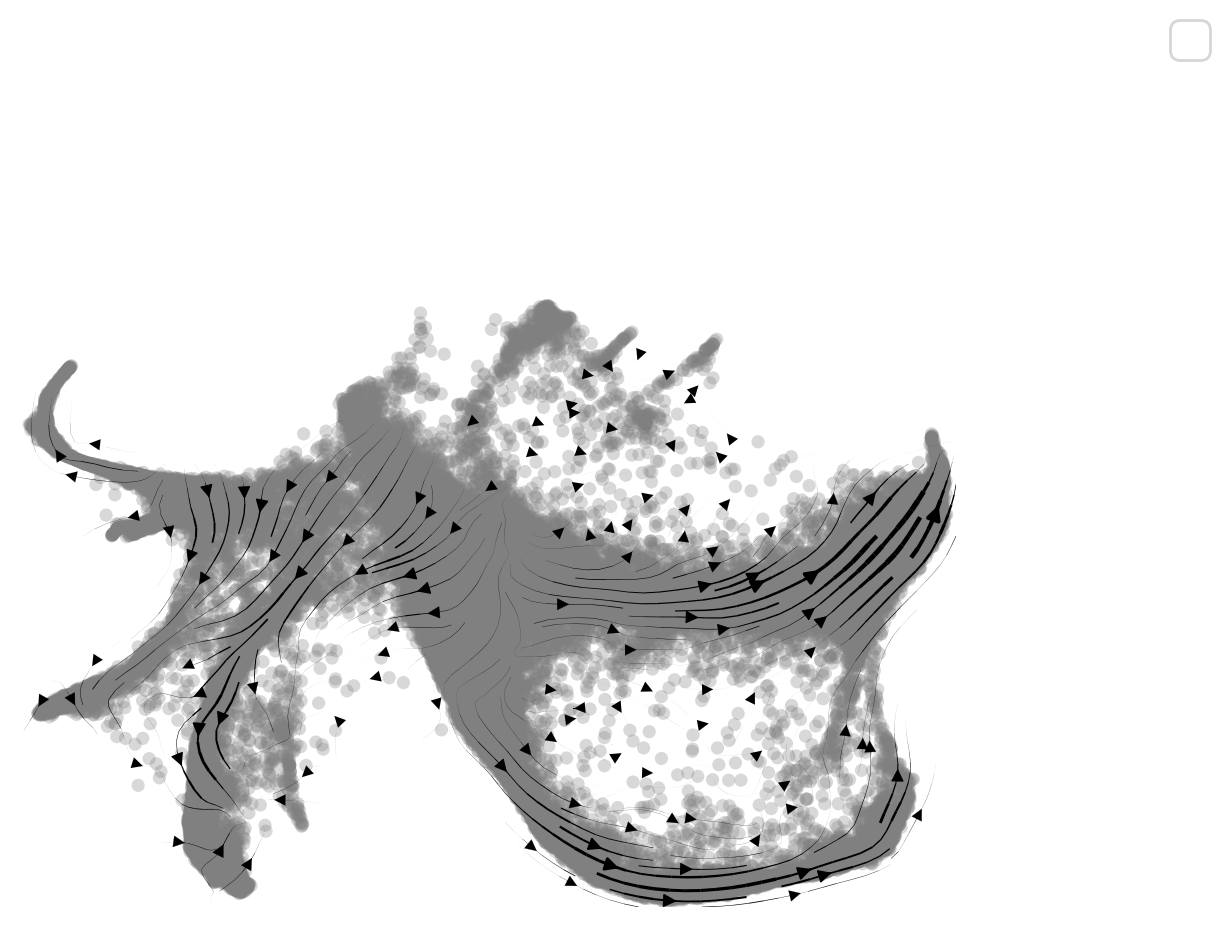

In [20]:
scv.set_figure_params('scvelo', transparent=True, fontsize=10, dpi_save=400,color_map='viridis')
fig = plt.figure()
ax = scv.pl.velocity_embedding_stream(adata, basis="X_emb", smooth=0.5, title="", legend_loc="none", show=False)
legend =ax.legend(bbox_to_anchor=[1.25, 1.5], loc='upper center', ncol=6,frameon=True, prop={'size': 18})

In [21]:
scv.tl.velocity_confidence(adata)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


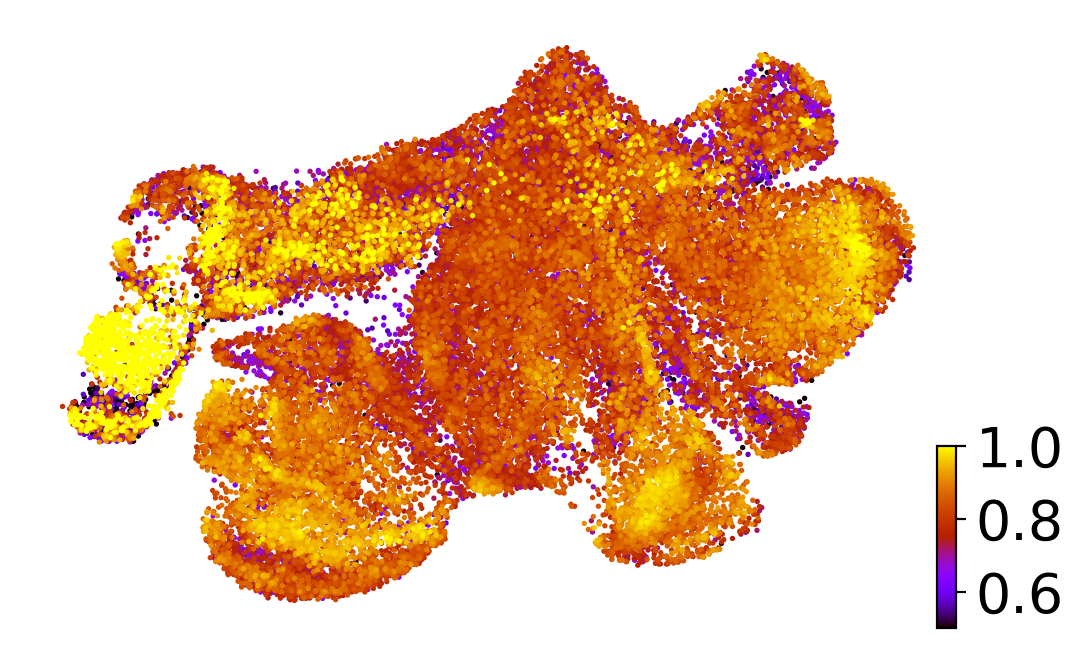

In [22]:
scv.set_figure_params('scvelo', fontsize=20)
scv.settings.presenter_view = False
scv.pl.scatter(adata, color='velocity_confidence',
               perc=[2, 98],
               cmap='gnuplot',
               vmid=0.75,
               rescale_color=[0.5, 1.0],
               size=15,
               title="",
               #save="velconf_pancreas1415_scvelo.png"
              )

In [9]:
#adata.write("/home/icb/jonas.flor/precomputed_data/scvelo_larry_pre.h5ad")

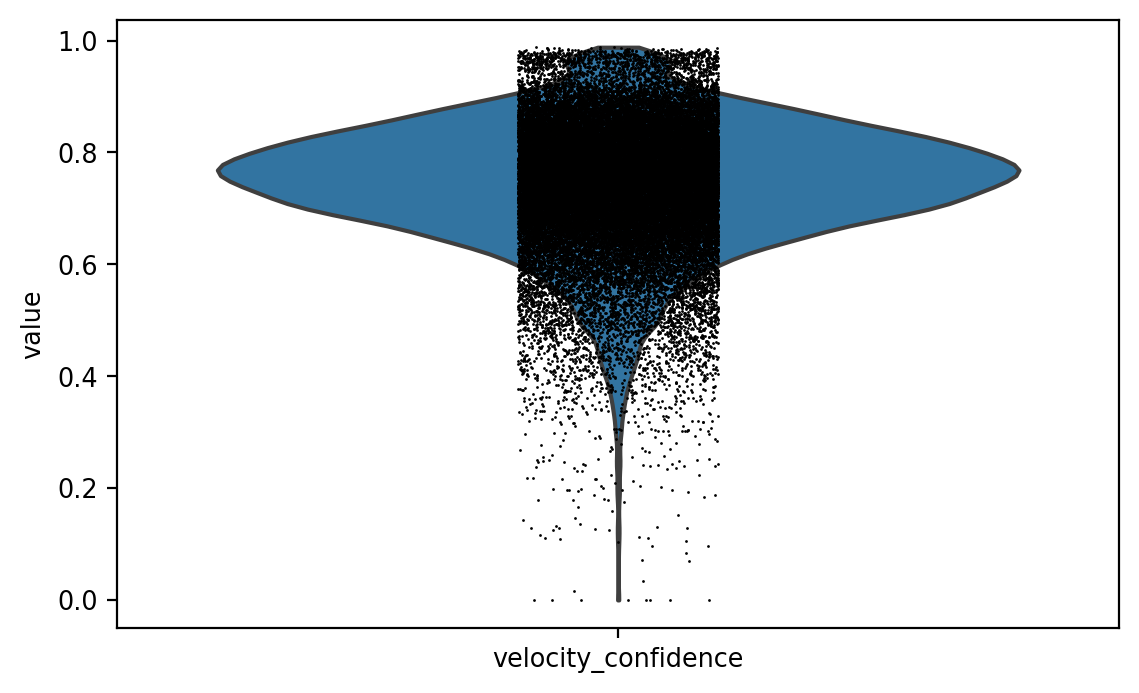

In [26]:
sc.pl.violin(adata, keys='velocity_confidence')

In [27]:
#adata.write("/home/icb/jonas.flor/precomputed_data/scvelo_gast_pre.h5ad")